Training directory: C:\Users\Desk\Desktop\Github\Image-Recognition\data\fruits-360\Training
Test directory: C:\Users\Desk\Desktop\Github\Image-Recognition\data\fruits-360\Test
Number of training samples: 67692
Number of test samples: 22688


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


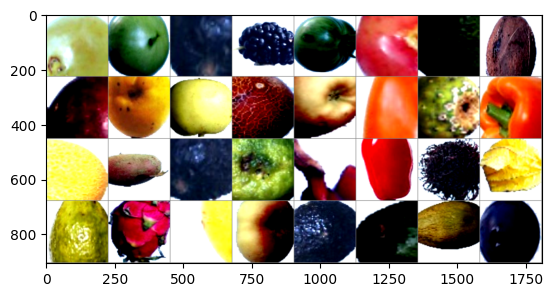

Grape White Tomato not Ripened Avocado ripe Mulberry


In [1]:
import os
import torch
import torchvision as vision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Get the current directory
current_dir = os.getcwd()

# Join the current directory with the path to the dataset
train_dir = os.path.join(current_dir,'data', 'fruits-360', 'Training')
test_dir = os.path.join(current_dir,'data', 'fruits-360', 'Test')

print(f'Training directory: {train_dir}')
print(f'Test directory: {test_dir}')


# Define the transforms for the training and test datasets
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Verify the datasets and dataloaders
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of test samples: {len(test_dataset)}')

# Optionally, display some sample images from the training set
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(vision.utils.make_grid(images))
# Print labels
print(' '.join('%5s' % train_dataset.classes[labels[j]] for j in range(4)))



In [2]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pre-trained ResNet101 model
model = models.resnet101(pretrained=True)

# Modify the final fully connected layer for the number of classes in your dataset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Move the model to the appropriate device
model = model.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


def train(model, train_loader):
    # Training loop
    num_epochs = 12
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            # Print statistics
            running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
    
    

model_load_path=os.path.join(current_dir,'resnet101_fruits.pth')
load_weights=True
loss_values=None
if load_weights:
    model.load_state_dict(torch.load(model_load_path))
else:
    # Train and evaluate the model
    train(model, train_loader)

print('Finished Training')


C:\Users\Desk\anaconda3\envs\gpu3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Desk\anaconda3\envs\gpu3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Finished Training


Test Accuracy: 0.9983


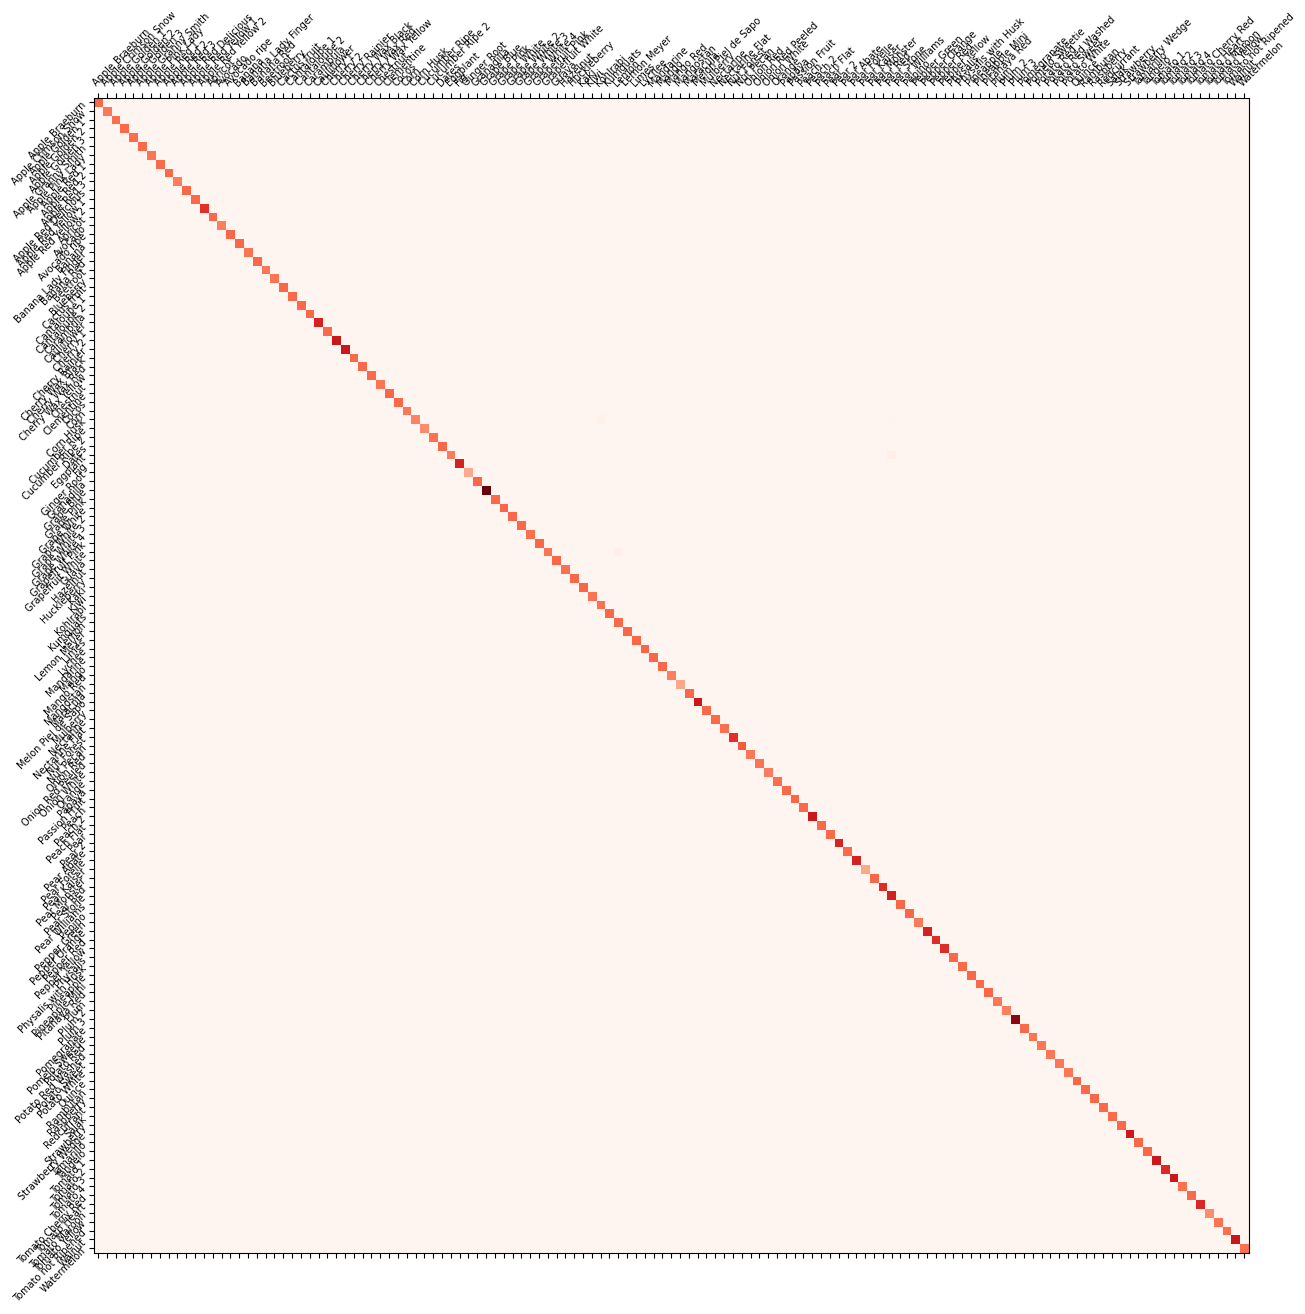

In [3]:
from sklearn.metrics import confusion_matrix, accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.4f}')

# Generate confusion matrix
cmat = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
def display_confusion_matrix(cmat, classes):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(classes)))
    ax.set_yticklabels(classes, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()

display_confusion_matrix(cmat, train_dataset.classes)


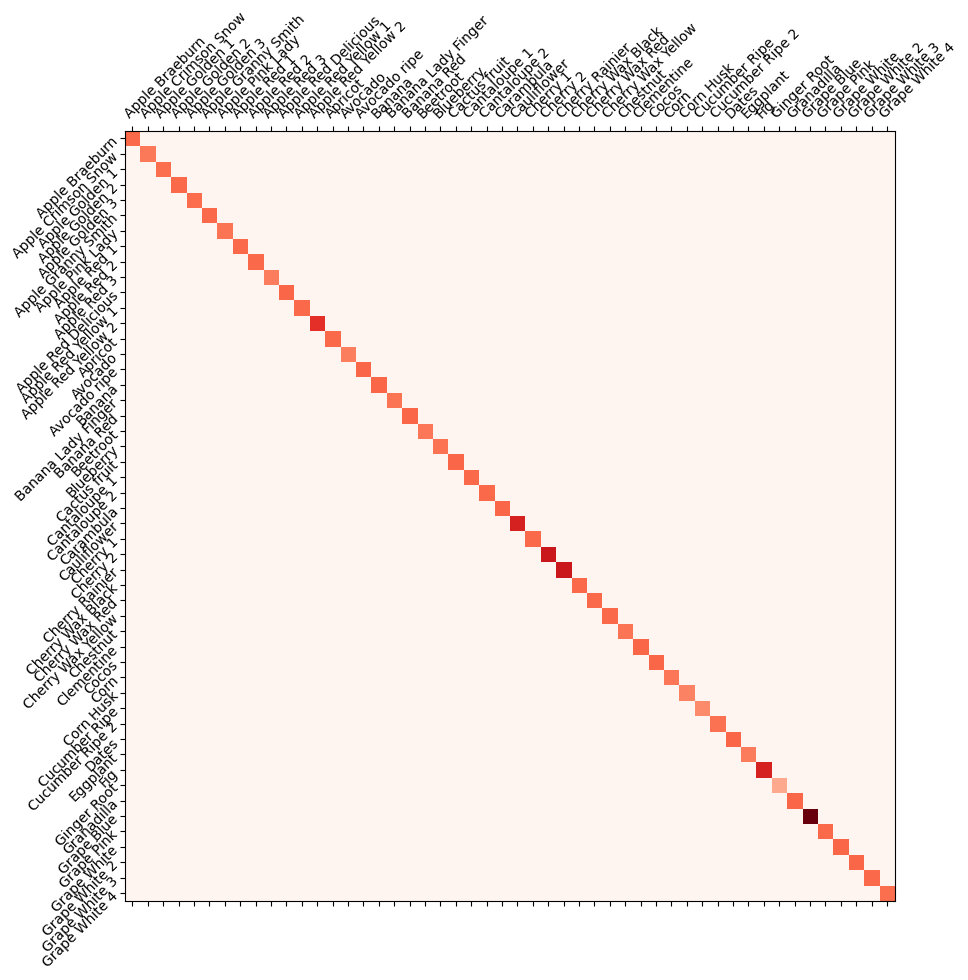

In [6]:
def display_confusion_matrix(cmat, classes, num_classes=25):
    if len(classes) > num_classes:
        selected_indices = np.arange(num_classes)
    else:
        selected_indices = np.arange(len(classes))
    
    selected_cmat = cmat[selected_indices, :][:, selected_indices]
    selected_classes = [classes[i] for i in selected_indices]
    
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.matshow(selected_cmat, cmap='Reds')
    
    ax.set_xticks(range(len(selected_classes)))
    ax.set_xticklabels(selected_classes, fontdict={'fontsize': 10})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    
    ax.set_yticks(range(len(selected_classes)))
    ax.set_yticklabels(selected_classes, fontdict={'fontsize': 10})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    plt.show()

# Assuming `cmat` is your confusion matrix and `train_dataset.classes` are your class names
display_confusion_matrix(cmat, train_dataset.classes)

In [7]:
# Specify the path where you want to save the model weights
model_save_path = 'resnet101_fruits.pth'
# Save the model weights
torch.save(model.state_dict(), model_save_path)
print(f'Model weights saved to {model_save_path}')

Model weights saved to resnet101_fruits.pth
